# Rapid Unsupervisd Detection of Events (RUDE) Example

In [1]:
import os
os.chdir('/home/mgfinley/dev/MAGPRIME') # Needed for development of branch

### Load data from Michibiki-1 Magnetometers and create data gap

/home/mgfinley/dev/MAGPRIME/magprime/.venv/lib/python3.12/site-packages/pymssa/mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


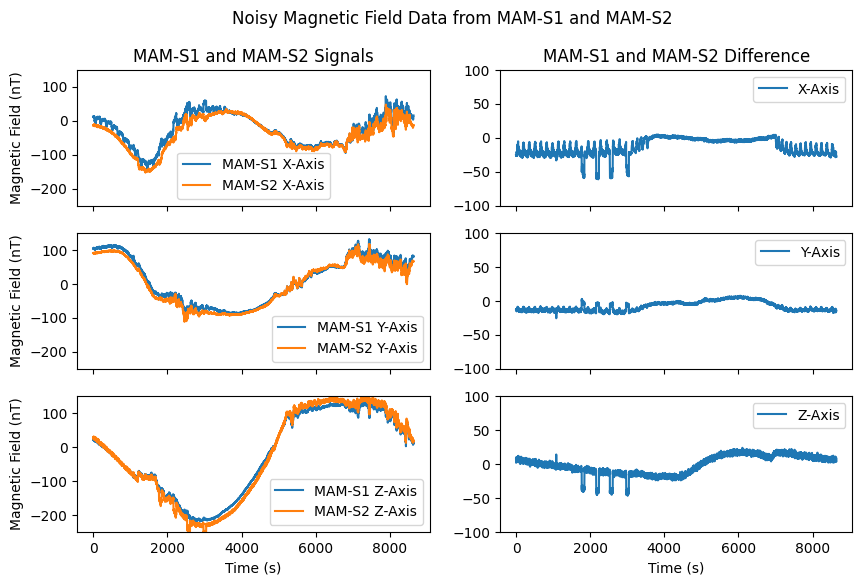

In [2]:
"Import the necessary modules"
from magprime import utility
import numpy as np
import matplotlib.pyplot as plt


B = utility.load_michibiki_data() # shape = (n_sensor, n_axis, n_samples)

"Decimate the data to 0.1 Hz because UBSS and MSSA are slow methods and it will take a long time to run on 86,400 data points"
B = B[:,:,::10]

"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B[0,0], label="MAM-S1 X-Axis")
axs[0,0].plot(B[1,0], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B[0,1], label="MAM-S1 Y-Axis")
axs[1,0].plot(B[1,1], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B[0,2], label="MAM-S1 Z-Axis")
axs[2,0].plot(B[1,2], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend()
axs[0,1].set_ylim(-100, 100)

axs[1,1].plot(B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend()
axs[1,1].set_ylim(-100, 100)

axs[2,1].plot(B[1,2]-B[0,2], label="Z-Axis")
axs[2,1].set_ylim(-100, 100)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()



### Clean Data with WAIC-UP

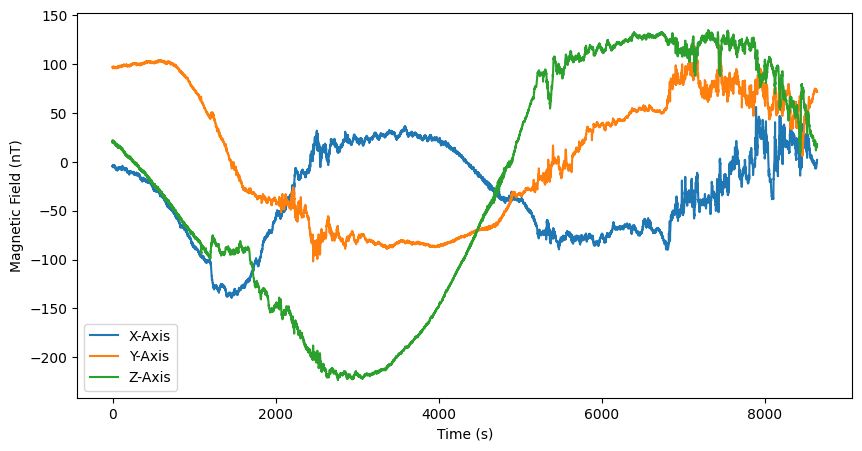

In [3]:
from magprime.algorithms import WAICUP

"Detrend the data"
WAICUP.uf = 1000
WAICUP.detrend = True

"Algorithm Parameters"
WAICUP.fs = .1
WAICUP.dj = 1/12

"Clean the data"
B_waicup = WAICUP.clean(np.copy(B))

"Plot the data"
plt.figure(figsize=(10, 5))
plt.plot(B_waicup[0], label="X-Axis")
plt.plot(B_waicup[1], label="Y-Axis")
plt.plot(B_waicup[2], label="Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Magnetic Field (nT)")
plt.legend()


### Detect Auroral Oval with EventDetector

In [4]:
from magprime.algorithms.anomaly import RUDE
window_length = 600 # 5 sec
nu = 0.5
fs = 0.1
bz_anomaly_flags = RUDE.anomaly_detection(np.copy(B_waicup[2]), fs, window_length, nu)


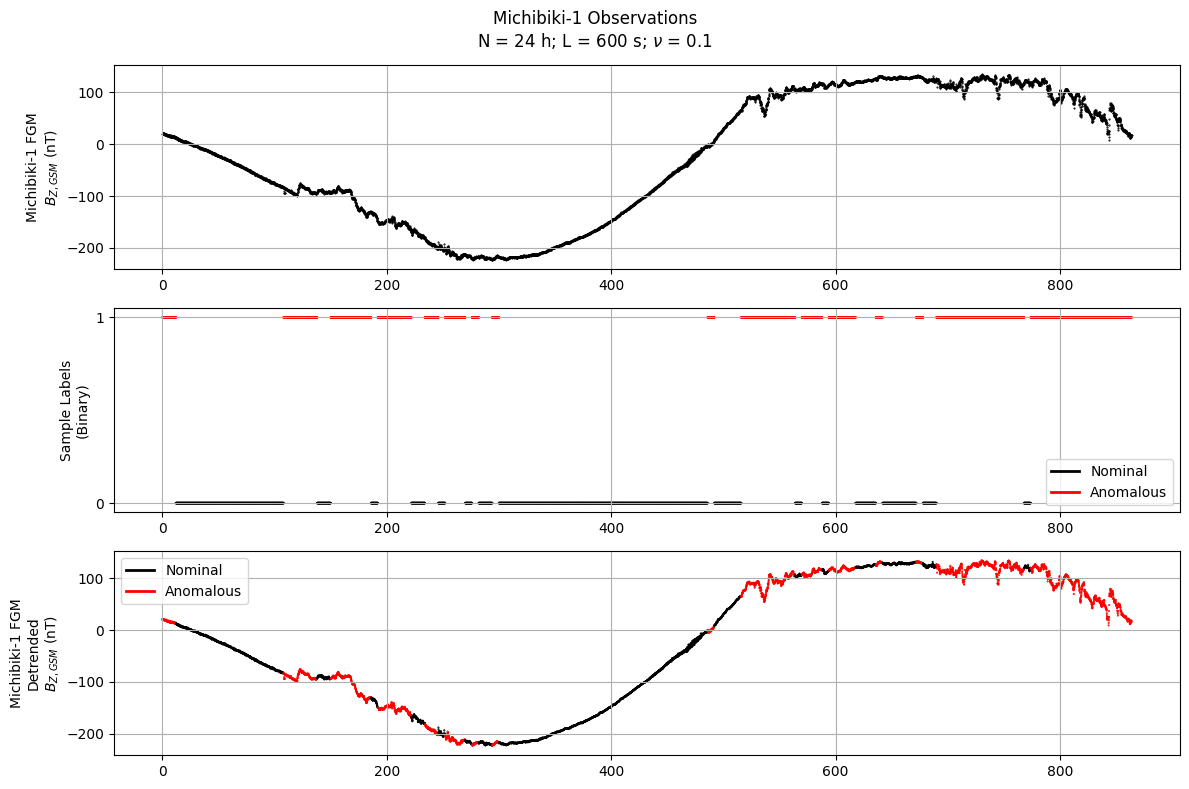

In [5]:
# Develop cmap for scatterplots
bz_colormap = ['red' if bz_anomaly_flags[i] > 0 else 'black' for i in range(len(bz_anomaly_flags))]
t = np.arange(0, len(B_waicup[2])/10, 0.1)

# Plot
plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.scatter(t,B_waicup[2], color='black', s=1, marker='.')
plt.ylabel('Michibiki-1 FGM\n$B_{Z,GSM}$ (nT)')
plt.grid()
plt.subplot(3,1,2)
plt.scatter(t, bz_anomaly_flags, marker='.', color=bz_colormap, s=2)
plt.yticks([0, 1])
plt.grid()
plt.ylabel('Sample Labels\n(Binary)')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linewidth=2),
                Line2D([0], [0], color='red', linewidth=2)]
plt.legend(custom_lines, ['Nominal', 'Anomalous'])
plt.subplot(3,1,3)
plt.scatter(t, B_waicup[2], color=bz_colormap, s=1, marker='.')
plt.ylabel('Michibiki-1 FGM\nDetrended\n$B_{Z,GSM}$ (nT)')
plt.grid()
plt.legend(custom_lines, ['Nominal', 'Anomalous'])
plt.suptitle('Michibiki-1 Observations\nN = 24 h; L = 600 s; $\\nu$ = 0.1')
plt.tight_layout()

# Rapid Unsupervised Detection of Events with Recursive PCA (RUDER) Example

Load two weeks of magnetometer data from Swarm Alpha (C component of NEC) as DataStream

In [6]:
from magprime.algorithms import RUDER

input_filename = 'magprime/utility/SPACE_DATA/SwarmA_2014Feb1-15.txt'
data_stream = RUDER.DataStream(input_filename)

Define the filename for output weights, apply RUDER.

In [7]:
output_filename = 'magprime/utility/SPACE_DATA/SwarmA_2014Feb1-15_AnomalyWeights.txt'
window_length = 5*60 # Five minutes
initialization_length = 48 # 48 times window_length gives four hours
col_n = 1 # Column of the input file that contains the data to be analyzed (NEC nadir)
nu = 0.05
ruder_model = RUDER.RUDER(window_length = window_length, initialization_length = initialization_length, data_stream = data_stream, col_n = col_n, filename = output_filename, nu=0.05)


Finished Processing...


Visualize as an average weight per lat/lon bin

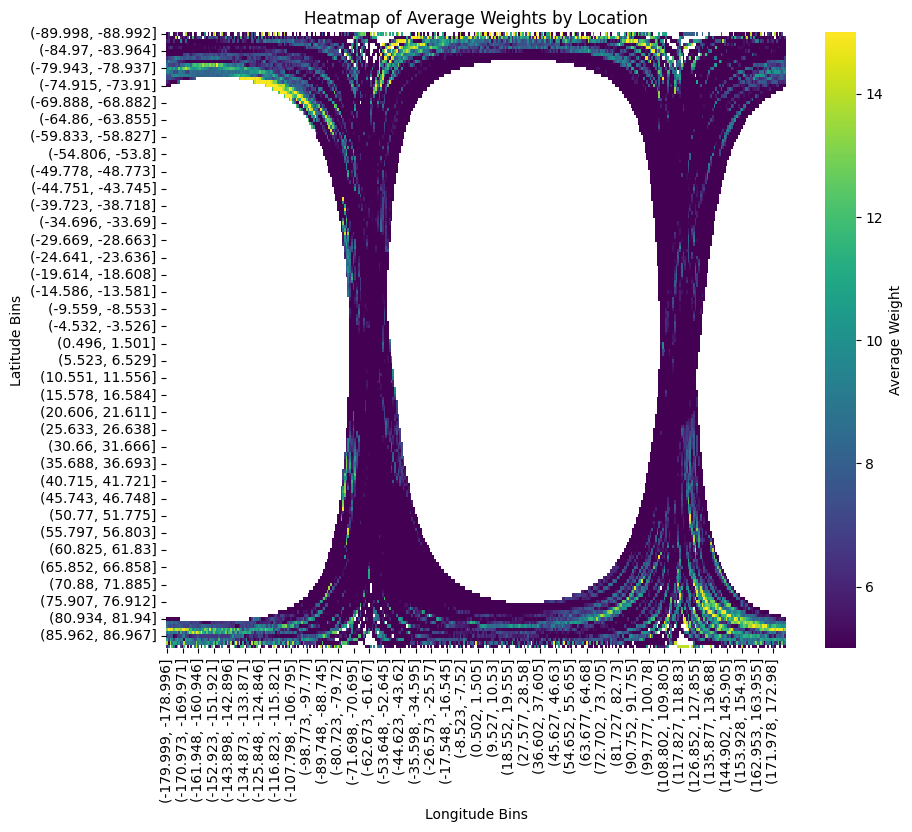

In [8]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

anomaly_df = pd.read_csv(output_filename, header=None)
df = pd.read_csv(input_filename)
df = df[:len(anomaly_df)]
df.insert(0, 'AnomalyFlag', anomaly_df[0]) # Combine into a single dataframe

# Group by latitude and longitude, compute mean weight
df_agg = df.groupby(['sm_lat', 'sm_lon'])['AnomalyFlag'].mean().reset_index()

# Define bins for latitude and longitude
lat_bins = np.linspace(df_agg['sm_lat'].min(), df_agg['sm_lat'].max(), 180)
lon_bins = np.linspace(df_agg['sm_lon'].min(), df_agg['sm_lon'].max(), 360)

# Bin the data into a 2D grid
df_agg['lat_bin'] = pd.cut(df_agg['sm_lat'], bins=lat_bins, include_lowest=True)
df_agg['lon_bin'] = pd.cut(df_agg['sm_lon'], bins=lon_bins, include_lowest=True)

# Pivot to create a 2D array of average weights
heatmap_data = df_agg.pivot_table(values='AnomalyFlag', index='lat_bin', columns='lon_bin', aggfunc='mean')

# Display
plt.figure(figsize=(10, 8))
seaborn.heatmap(heatmap_data, cmap='viridis', annot=False, cbar_kws={'label': 'Average Weight'}, vmin=5, vmax=15)
plt.title('Heatmap of Average Weights by Location')
plt.xlabel('Longitude Bins')
plt.ylabel('Latitude Bins')
plt.show()